# NoReFry

This Jupiter notebook goes step by step through the algorithm so it should be well understood and used for other data.

## Import necessary modules

In [1]:

import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt
import norefry_library as nrfl


## Prepare input

List `filenames` consists of full or relative paths to data files. These files consist of table of data which can be loaded by `np.loadtxt` command.

In [2]:
filenames = ['data/test_data_1.dat',
             'data/test_data_2.dat',
             'data/test_data_3.dat',
             'data/test_data_4.dat',
             'data/test_data_5.dat',
             'data/test_data_6.dat',
             'data/test_data_7.dat']

Array `energies` involves energies at which given data were acquired.

In [3]:
energies = np.array([4.227,6.124,10.182,16.717,25.699,45.753,74.263])

Finally, define `width` and `height` of data to get proper dimensions.

In [4]:
width = 1.392    # Real width of data [mm]
height = 1.044   # Real height of data [mm]

## Load data and create d-scan matrix

Init d-scan matrix `d0` which columns will be filled by individual depth scans. As the dimensions are not know yet init as `None`.

In [5]:
d0 = None

### Optional downsampling

Downsample depth scans. Definition of `DS` matrix can be realy time-consuming in case of large input images. Set `N` to `None` if not required. It defaults to image width x height, i.e. 640*480 = 307200 in this example.

In [6]:
N = None

### Load data

Fill d-scan matrix `d0` with data loaded from extern files. Data must be set positive and its values should be within a *normal* range. In this case, the original data is in nanometers and combination of small and large values may potentialy result in singular matrices. Input data is thus multiplied by `1e9`.

#### Note to data dimensions and plotting

``Numpy`` loads text file of `M` rows and `N` columns to `MxN` matrix. The first coordinate would therefore indicate rows, i.e. `y` direction. In order to access data as `data[x,y]`, data are transposed upon reading. ``Matplotlib`` plotting command `pyplot.imshow` however prints the first coordinate (`x`) in vertical direction. Therefore, second transposition is used to plot output. Pseudocode:

```
data = transpose(file with matrix of M rows and N columns)
size of data = M x N
data[x,y]; where x = [0,M), y = [0,N)
plt.imshow(data.T) so x-axis is [0,M) and y-axis is [0,N)
```

#### Remove linear background

Linear background of the data is subtracted using `removeLinearBackground()` function which can be found in `norefry_library.py`. It calculates plane from 3 points. For better precision, radius of the points can be given as well. Use `plot=True` argument to see results and modify location of points so the fit is the most accurate.

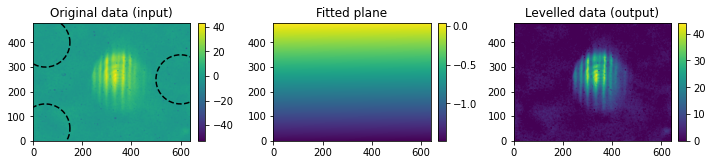

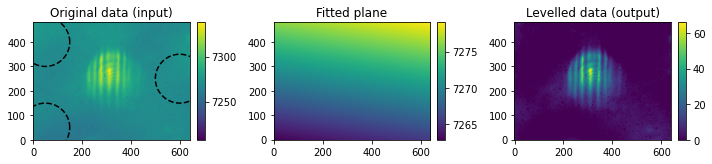

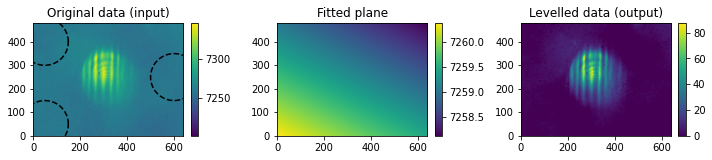

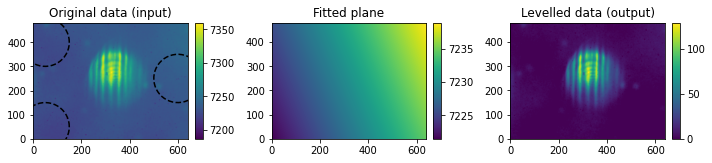

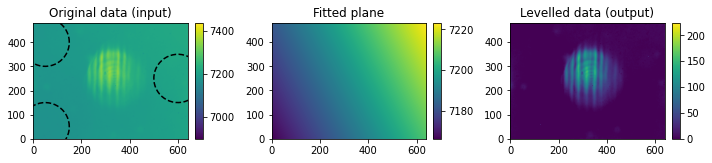

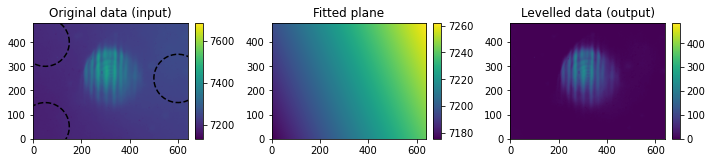

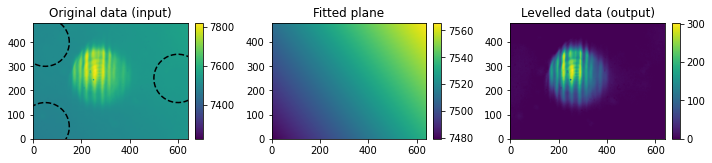

In [7]:
for filename in filenames:

    # Load data from file
    data = (-np.loadtxt(filename)*1e9).T

    # Remove linear background by providing three points and radius
    points = np.array([[50,50],[50,400],[600,250]])
    data = nrfl.removeLinearBackground(data, points, radius=100, plot=True)
    data[data<5] = 0    # Remove data below certain threshold

    nX,nY = data.shape  # Get dimensions of data
    depth_scan = -np.sort(-np.reshape(data,nX*nY))  # Sort data descending

    # Downsampling of depth scan
    if N is None:
        N = nX*nY
    elif N != nX*nY:
        f = interpolate.interp1d(np.arange(0,nX*nY),depth_scan)
        x2 = np.arange(0,N)*nX*nY/N
        depth_scan = f(x2)

    # Fill d-scan matrix
    if d0 is None:
        # Create first column
        d0 = depth_scan.reshape(1,N)
    else:
        # Add new column to existing one
        d0 = np.append(d0,depth_scan.reshape(1,N),axis=0)




Cropping of negative data causes there are many redundant zeros in `d0`. Here we find last non-zero element and crop `d0` to new size `d0N`.

In [8]:
d0N = np.max(np.nonzero(d0))+1
d0 = d0[:,0:d0N]

Data can be optionaly edited when some strange features appear.

*Hey, these data is real, taken by WLI microscope so there can be some strange things, right?*

In [9]:
d0[-1,0] = d0[-1,1]
d0[-2,0:1] = d0[-2,2]

Construct area vector of D-scan

In [10]:
S0 = np.arange(0,d0N)*(width*height/N)

### Plot dept scans

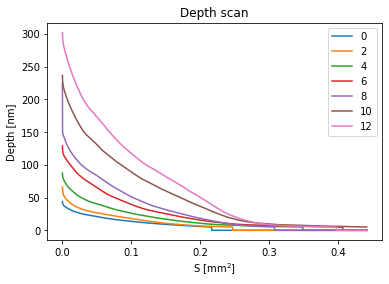

In [11]:
fig = plt.figure()
plt.title('Depth scan')
for i in range(len(d0)):
    plt.plot(S0,d0[i],label=str(i+i))
plt.xlabel(r'S [mm$^2$]')
plt.ylabel('Depth [nm]')
plt.legend()
plt.show()

## Initialization of matrices

Dimensions of matrix (`nD` and `nS`) are experimentally quessed. Depth scans (i.e. curves with constant energy) should be continuous for best results.
- large matrix does not ensures convergence
- too small matrix does not have enough resolution

In [12]:
# Size in depth-direction, step, axis vector
nD = 200; dD = np.max(d0)/(nD-1); d_axis = np.arange(0,nD)*dD
# Size in area-direction, step, axis vector
nS = 200; dS = np.max(S0)/(nS-1); s_axis = np.arange(0,nS)*dS

**Depth scan matrix (`DS`):** It is identical to the depth scan but shaped as matrix. Values of the pixels are pulse energies corresponding to the given imprint.

**Inverse depth scan matrix (`iDS`):** Same as `DS` but values equal to 1/energy.

In [13]:
DS = np.zeros((nD,nS))
iDS = np.zeros((nD,nS))

For loop goes through depth scans in `d0`. Indices `id` and `iS` of `DS` matrix are calculated and corresponding element is set to given energy.

In [14]:
for i in range(len(d0)):
    for d in range(d0N):
        id = np.round(d0[i,d]/dD).astype(int)   # index of depth
        iS = np.round(S0[d]/dS).astype(int)     # index of area
        if id>=0 and iS>=0:
            DS[id,iS]  = energies[i]
            iDS[id,iS] = 1/energies[i]

`DS` matrix may contain gaps in columns. Following procedure removes these gaps. This is important especially for large matrices.

In [15]:
for iS in range(nS):
    for id in range(nD):
        if DS[id,iS]>0:
            e = DS[id,iS]
            for id2 in range(id,nD):
                if DS[id2,iS] == e:
                    for id3 in range(id,id2):
                        DS[id3,iS]  = e
                        iDS[id2,iS] = 1/e

### Plot DS matrix

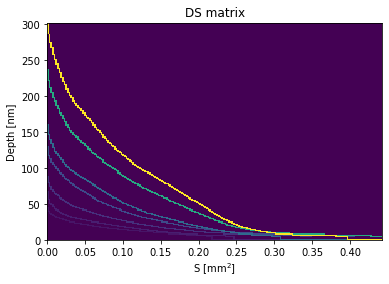

In [16]:
fig = plt.figure()
plt.imshow(DS,origin='lower',aspect='auto',interpolation='none',
    extent =[s_axis.min(), s_axis.max(), d_axis.min(), d_axis.max()])
plt.title('DS matrix')
plt.xlabel(r'S [mm$^2$]')
plt.ylabel('Depth [nm]')
plt.show()

## Init f-scan and dose vector

In [17]:
DS_count = (DS>0)

E0 = (DS[:,0]).copy()       # just to keep original value of E
E = E0.copy()               # E is a dose vector
E_count = (E>0)             # nonzero E-counter
E_avg = E.copy()            # averaged dose vector
E_avg_count = 1*(E_avg>0)   # counter of non-negative values of E_avg

f = np.zeros(nS)            # fluence scan vector
f_count = f.copy()          # counter of f-scan
f_avg = f.copy()            # averaged f vector
f_avg_count = (f_avg>0)     # counter of non-negative values of f_avg

## Iteraction loop

Convergence is usually quite fast, 100 steps should be enough. This procedure is described in appendix of the [publication](https://doi.org/10.1364/OE.396755).

In [18]:
no_iterations = 100

for i in range(no_iterations):

    df = E_avg.dot(iDS)
    f = f + df
    f_count = f_count + E_avg_count.dot(DS_count)
    f_avg[f_count>0] = f[f_count>0] / f_count[f_count>0]

    f_avg_count = 1*(f_avg>0)

    f_avg = (f_avg-np.min(f_avg))/(np.max(f_avg)-np.min(f_avg))
    f_avg[0] = 1

    dE = DS.dot(f_avg)
    E = E + dE
    E_count = E_count + DS_count.dot(f_avg_count)
    E_avg[E_count>0] = E[E_count>0] / E_count[E_count>0]

    E_avg_count = 1*(E_avg>0)

## Plot results

### Calibration curve

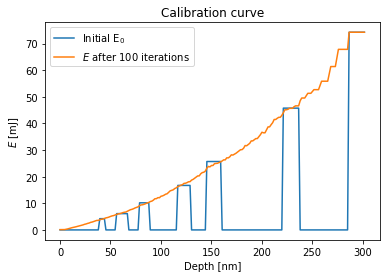

In [19]:
fig = plt.figure()
plt.title('Calibration curve')
plt.plot(d_axis,E0,label=r'Initial E$_0$')
plt.plot(d_axis,E_avg,label=r'$E$ after '+str(no_iterations)+' iterations')
plt.xlabel('Depth [nm]')
plt.ylabel(r'$E$ [mJ]')
plt.legend()
plt.show()

### Fluence scan

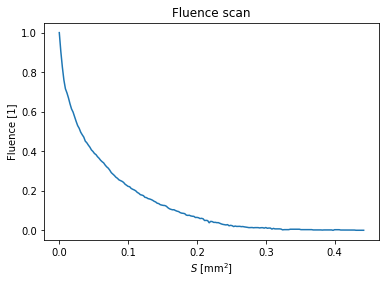

In [20]:
fig = plt.figure()
plt.title('Fluence scan')
plt.plot(s_axis,f_avg)
plt.xlabel(r'$S$ [mm$^2$]')
plt.ylabel('Fluence [1]')
plt.show()